In [1]:
%cd "../fiberphotopy"

C:\Users\mceau\Documents\fiberphotopy\fiberphotopy


In [2]:
import behavioral_data, fp_utils, fiber_data, analysis
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import os
import datetime

import importlib
def rel():
    for mod in [behavioral_data, fp_utils, fiber_data, analysis]:
        importlib.reload(mod)
rel()

In [3]:
def sac_plot(filename,title=None,ax=None,figsize=(40,10),saving_dest='.'):
    if title == None:
        title = filename[:-4].split('/')[-1]
    save = False
    if not ax:
        fig, ax = plt.subplots(1,figsize=figsize)
        save = True
    obj = behavioral_data.BehavioralData(filename)
    # periods with lever out
    df_l1 = obj.get('L1')
    obj.l1_out = df_l1[(df_l1['_P'] == 1)]['TIME'].values/1000 ## lever is out
    obj.l1_in = df_l1[(df_l1['_P'] == 0)]['TIME'].values/1000 ## lever is in
    lever = obj._interval(obj.l1_out,obj.l1_in,obj.end)
    for n,(a,b) in enumerate(lever):
        ax.axvspan(a,b,alpha=0.5,color='gray',label='_'*n+'Lever Out')

    # licks
    obj.lk1_start  = obj._extract(5, 1,'_V',1)
    obj.lk1_end    = obj._extract(5, 1,'_V',0)
    obj.LK1        = obj._interval(obj.lk1_start, obj.lk1_end, obj.end)
    obj.LKduration = np.array([b-a for a,b in obj.LK1])
    ax.bar(obj.lk1_start, obj.LKduration,label='Licking Time',width=1,color='mediumblue')
    ax.eventplot(obj.lk1_start,lineoffsets=-0.3,linelengths=0.5,linewidths=0.6,color='b',label='Licks')

    # lever 
    ## visits / lever out
    obj.l1_press_out = df_l1[(df_l1['_V'] == 1) & (df_l1['_P'] == 1) & (df_l1['_L'] != 0)]['TIME'].values/1000
    # visits / lever in
    obj.l1_press_in = df_l1[(df_l1['_V'] == 1) & (df_l1['_P'] == 0) & (df_l1['_L'] != 0)]['TIME'].values/1000 #['_X'][-1] = len
    #plt.eventplot(obj.l1_in,lineoffsets=16,linelengths=1,linewidths=0.5,color='r',label='lever in')
    #plt.eventplot(obj.l1_out,lineoffsets=16,linelengths=1,linewidths=0.5,color='b',label='lever out')
    ax.eventplot(obj.l1_press_in,lineoffsets=-1.2,linelengths=1,linewidths=0.5,color='purple',label='Lever Press (in)')
    ax.eventplot(obj.l1_press_out,lineoffsets=-1.2,linelengths=1,linewidths=0.5,color='darkgreen',label='Lever Press (out)')

    # inj
    ax.eventplot(obj.inj1,lineoffsets=-2.2,linelengths=1,linewidths=0.5,color='k',label='Administration')

    # np
    ax.eventplot(obj.np1,lineoffsets=-3.2,linelengths=1,linewidths=0.5,color='r',label='Nose Pokes')
    ax.set_ylim((-3.7,obj.LKduration.max()))
    ax.set_ylabel('(seconds)')
    ax.set_xlabel('(seconds)')
    ax.set_title(title)
    ax.legend(loc='upper right')
    if save:
        prefix = saving_dest+'/'+filename[:-4].split('/')[-1]
        plt.savefig(prefix+'.png',bbox_inches='tight')
        plt.savefig(prefix+'.svg',dpi=1200)
        plt.savefig(prefix+'.pdf',dpi=1200)
        
#file = 's://Datas équipe Deroche/Eq-DEROCHE_1.hbk/Datas/Rats/2022/AA22R/Données brutes AA22SA + CM/J47sac/bsa07042022s1c04_01.dat'
#sac_plot(file)

root = "s://Datas équipe Deroche/Eq-DEROCHE_1.hbk/Datas/Rats/2022/AA22R/Données brutes AA22SA + CM"
full_paths = [a for A in [[root+'/'+folder+'/'+i for i in os.listdir(root+'/'+folder) if '.dat' in i] for folder in os.listdir(root)] for a in A if 'J29sac0' not in a]

full_paths = [a for a in full_paths if 'sac' in a] #!!
dat_prefix = [i.split('/')[-1].split('.dat')[0] for i in full_paths]
date_str = [a.split('sa')[1][:8] for a in dat_prefix]
dates = [datetime.datetime(day=int(a[:2]),month=int(a[2:4]),year=int(a[4:])) for a in date_str]
cages = [int(a.split('_')[0].split('c')[-1]) for a in dat_prefix]
df = pd.DataFrame({'name' : dat_prefix,
                   'cage' : cages,
                   'date' : dates,
                   'path' : full_paths})

In [4]:
datafolder = "../../DATA/lever/"
imagefolder = "../../DATA/graphical_summaries/"

In [5]:
paths = [datafolder+folder+'/'+i for folder in os.listdir(datafolder) for i in os.listdir(datafolder+folder)]
names = [i.split('/')[-1].split('.dat')[0] for i in paths]
dates = [datetime.datetime(day=int(a[3:5]),month=int(a[5:7]),year=int(a[7:11])) for a in names]
cages = [int(i.split('c')[-1].split('_')[0]) for i in names]
df = pd.DataFrame({'name' : names,
                   'cage' : cages,
                   'date' : dates,
                   'path' : paths})
selected_cages = {'rat 2' : 1,
                  'rat 10': 2,
                  'rat 11': 3,
                  'rat 14': 4,
                  'rat 31': 6,
                  'rat 32': 7,
                  'rat 39': 8}
selected_dates = list(set(df.date.values))

In [6]:
def multiplot(df,by='cage'):
    if by == 'cage': df.sort_values(['cage','date'],inplace=True)
    if by == 'date': df.sort_values(['date', 'cage'],inplace=True)
    size = len(df)
    fig,axes = plt.subplots(size,figsize=(40,10*size))

    for n,i in enumerate(df.index):
        name,cage,date,path = df.iloc[i,:]
        rat = [a for a,b in selected_cages.items() if b == cage][0]
        title = f"{rat.upper()} (c{cage}) {str(date)[:10]} ({path})"
        sac_plot(path,title=title,ax=axes[n])
    plt.savefig(imagefolder+str(datetime.datetime.now())[:10]+_+by+'.png')
    plt.savefig(imagefolder+str(datetime.datetime.now())[:10]+_+by+'.svg',dpi=1200)
    plt.savefig(imagefolder+str(datetime.datetime.now())[:10]+_+by+'.pdf',dpi=1200)

Importing ../../DATA/lever/J43sac/bsa01042022s1c01_01.dat...
Importing of ../../DATA/lever/J43sac/bsa01042022s1c01_01.dat finished in 0.03124833106994629 seconds
Importing ../../DATA/lever/J43sac/bsa01042022s1c02_01.dat...
Importing of ../../DATA/lever/J43sac/bsa01042022s1c02_01.dat finished in 0.03124856948852539 seconds
Importing ../../DATA/lever/J43sac/bsa01042022s1c03_01.dat...
Importing of ../../DATA/lever/J43sac/bsa01042022s1c03_01.dat finished in 0.02598428726196289 seconds
Importing ../../DATA/lever/J43sac/bsa01042022s1c04_01.dat...
Importing of ../../DATA/lever/J43sac/bsa01042022s1c04_01.dat finished in 0.0312504768371582 seconds
Importing ../../DATA/lever/J43sac/bsa01042022s1c06_01.dat...
Importing of ../../DATA/lever/J43sac/bsa01042022s1c06_01.dat finished in 0.028982162475585938 seconds
Importing ../../DATA/lever/J45sac/bsa05042022s1c01_01.dat...
Importing of ../../DATA/lever/J45sac/bsa05042022s1c01_01.dat finished in 0.031249523162841797 seconds
Importing ../../DATA/lever/

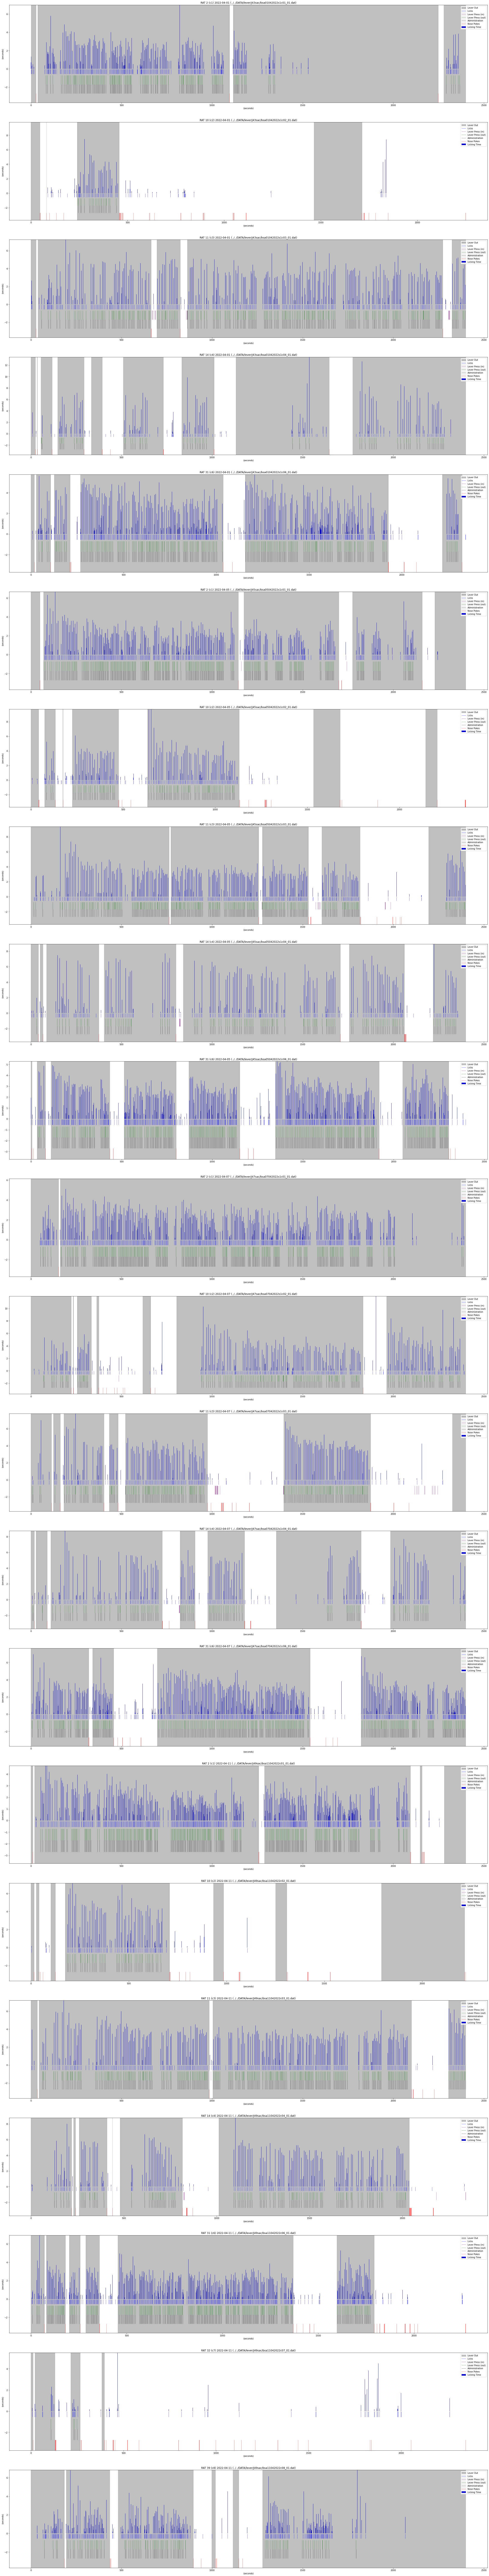

In [7]:
multiplot(df,by='date')


In [8]:
%ls

 Le volume dans le lecteur C s’appelle System
 Le numéro de série du volume est A698-0041

 Répertoire de C:\Users\mceau\Documents\fiberphotopy\fiberphotopy

12/04/2022  18:01    <DIR>          .
12/04/2022  18:01    <DIR>          ..
23/03/2022  16:36    <DIR>          .ipynb_checkpoints
16/03/2022  16:08                 0 __init__.py
19/04/2022  09:48    <DIR>          __pycache__
12/04/2022  18:01            17 667 analysis.py
12/04/2022  11:37            28 842 behavioral_data.py
07/04/2022  15:13            24 256 bsa07042022s1c04_01.png
07/04/2022  15:13           142 742 bsa07042022s1c04_01.svg
05/04/2022  10:43         1 761 896 cb11.svg
08/04/2022  10:30            15 676 fiber_data.py
25/03/2022  16:33             1 694 fp_utils.py
17/03/2022  15:11             6 965 info.py
05/04/2022  11:19         2 509 472 switchDND.svg
07/04/2022  14:25           212 440 test.txt
              11 fichier(s)        4 721 650 octets
               4 Rép(s)  884 050 907 136 octets libres
